In [1]:
import numpy as np

def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

## 데이터 불러오기


In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

bicycle = pd.read_csv('./dataset/train.csv')
bicycle.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833


In [3]:
data = bicycle

In [4]:
# 일자 분리
data_date= data.sort_values('date_time')
#data_date[data_date.columns[1:]] = data_date[data_date.columns[1:]].apply(lambda x: np.log(x))
data_date[['sky_condition','precipitation_form','humidity','Precipitation_Probability','wind_speed']] =data_date[['sky_condition','precipitation_form','humidity','Precipitation_Probability','wind_speed']].apply(lambda x : x*(-1))
data_date.corr()['number_of_rentals']

wind_direction               0.209996
sky_condition                0.384234
precipitation_form           0.420458
wind_speed                   0.464761
humidity                     0.147824
low_temp                     0.317741
high_temp                    0.423113
Precipitation_Probability    0.449225
number_of_rentals            1.000000
Name: number_of_rentals, dtype: float64

## 시계열 기준 확인

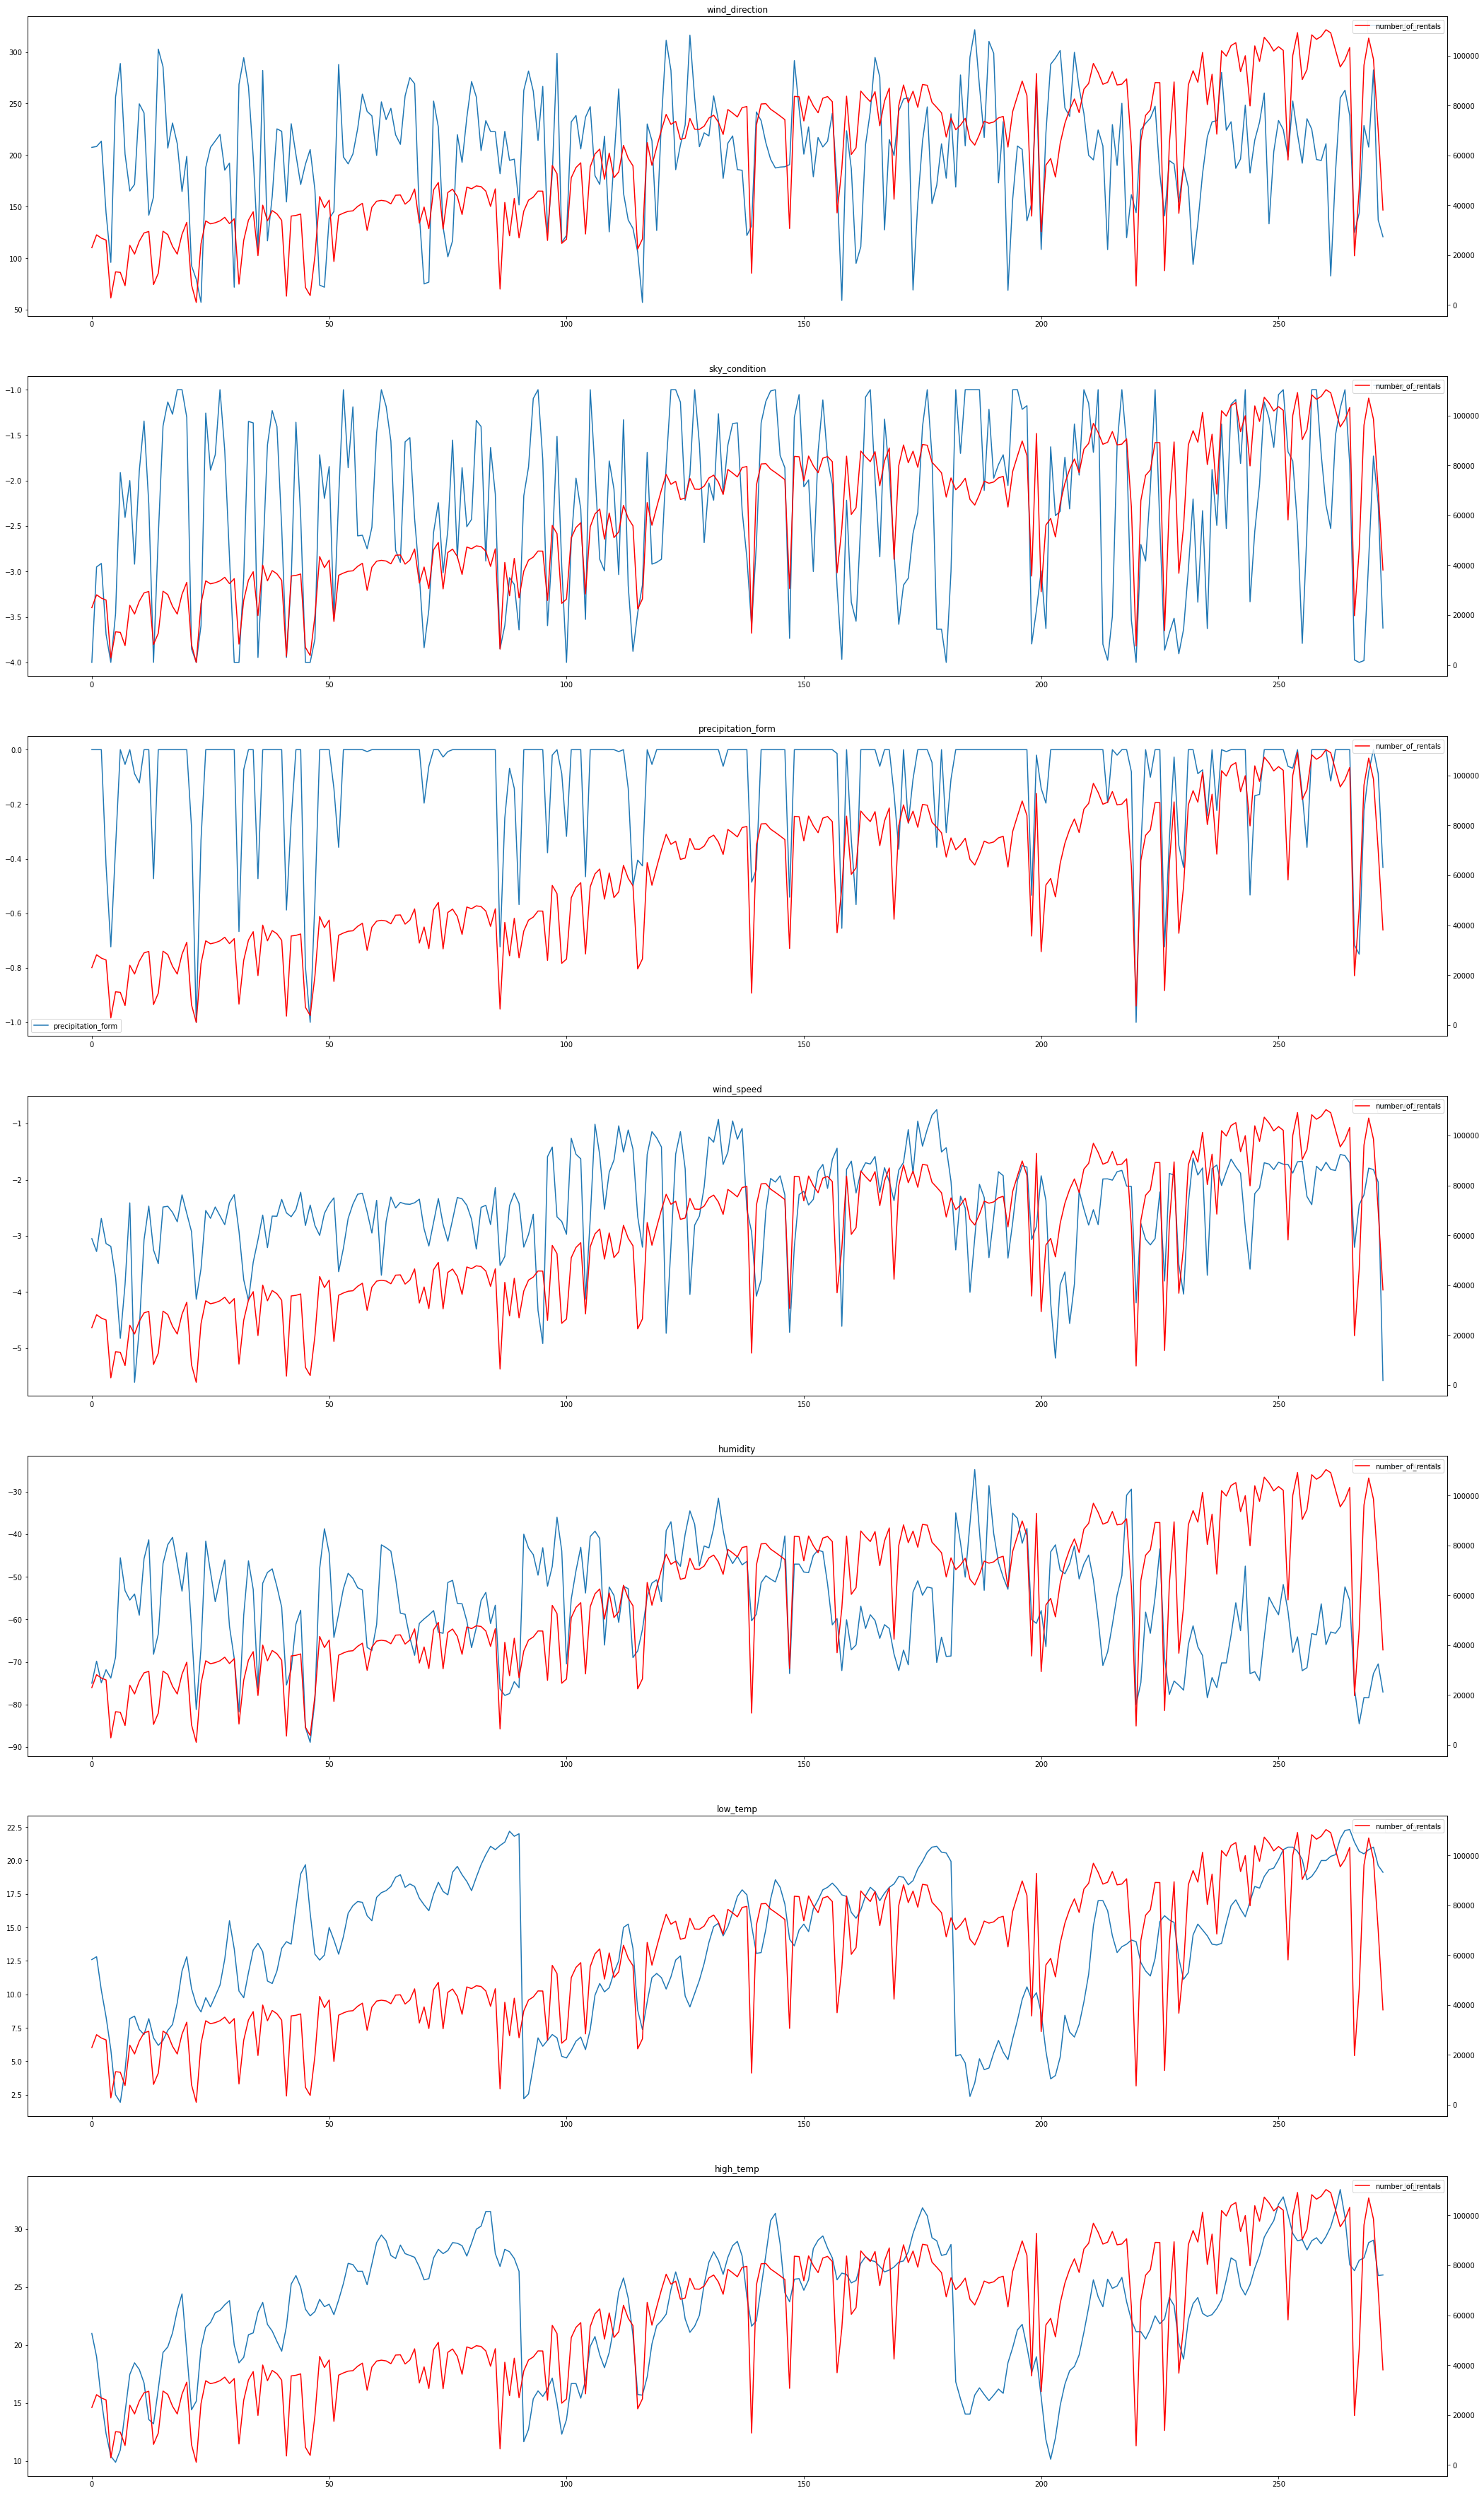

In [5]:
f, ax = plt.subplots(7, 1, figsize=(36, 64))
for i in range(0,7):
    data_date[data_date.columns[i+1]].plot.line(ax=ax[i])
    ax[i].set_title(data_date.columns[i+1])
    ax2 = ax[i].twinx()
    data_date[data_date.columns[9]].plot.line(color='r',ax=ax2)
    ax[i].legend(loc='best')
    ax2.legend(loc='best')
    plt.grid(True,axis='x')

# 날짜 정보 추가 1

In [6]:
def seperate_datetime(dataframe):
    year = []
    month = []
    day = []

    for date in dataframe.date_time:
        year_point, month_point, day_point = date.split('-') # - 기준으로 string을 나누고 list로 만듦 ex) '2016-04-01' -> ['2016', '04', '01']
        year.append(int(year_point))
        month.append(int(month_point))
        day.append(int(day_point))
    return year, month, day

def weekend(day):
    if day=="Sunday" or day=="Saturday":
        return 1
    else:
        return 0

def daycum(df):
    daylist= []
    for i in range(len(df)):
        day= df.loc[i,'Day']
        if df.loc[i,'Year'] > 2018:
            day += 365*(df.loc[i,'Year']-2018)
        if df.loc[i,'Month'] == 5:
            day += 30
        if df.loc[i,'Month'] == 6:
            day += 61
        daylist.append(day)
    return daylist

year, month, day = seperate_datetime(data)
    
data['Year'] = year
data['Month'] = month
data['Day'] = day

data["date_time"] = pd.to_datetime(data['date_time'])
week_day = data['date_time'].dt.day_name()
data["week_day"] = week_day

data['weekend'] = data['week_day'].apply(weekend)


data[['daycum']] = daycum(data[['Year','Month','Day']])


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(week_day)
data['week_day'] = le.transform(week_day)
data.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,Year,Month,Day,week_day,weekend,daycum
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,2018,4,1,3,1,1
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,2018,4,2,1,0,2
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,2018,4,3,5,0,3
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,2018,4,4,6,0,4
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,2018,4,5,4,0,5


## 온도 정보 추가

1. 일교차가 너무 큰 날씨
2. 너무 덥고 습한 날씨
3. 춥고 바람부는 날씨

In [7]:
# 1. "일교차가 너무 큰 날씨"를 알기 위한 정보
data['temp_diff_info'] = data['high_temp'] - data['low_temp']

# 2. "덥고 습한 날씨"를 알기 위한 정보
data['sweat_info'] = data['high_temp'] * data['humidity'] 

# 3. "춥고 바람부는 날씨"를 알기 위한 정보
data['cold_info'] = data['low_temp'] * data['wind_speed'] 

data.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,Year,Month,Day,week_day,weekend,daycum,temp_diff_info,sweat_info,cold_info
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,2018,4,1,3,1,1,8.400,1575.000000,38.430000
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,2018,4,2,1,0,2,6.188,1326.827000,41.997736
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,2018,4,3,5,0,3,5.004,1146.846764,27.739280
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,2018,4,4,6,0,4,4.056,888.628432,26.083056
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,2018,4,5,4,0,5,4.546,768.903064,18.717750


# 2. Feature Engineering by Computer

In [8]:

X  = data.drop(['date_time', 'number_of_rentals'], axis=1)
y = data.number_of_rentals
X


,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,Year,Month,Day,week_day,weekend,daycum,temp_diff_info,sweat_info,cold_info
0,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,2018,4,1,3,1,1,8.400,1575.000000,38.430000
1,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,2018,4,2,1,0,2,6.188,1326.827000,41.997736
2,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,2018,4,3,5,0,3,5.004,1146.846764,27.739280
3,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,2018,4,4,6,0,4,4.056,888.628432,26.083056
4,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2018,4,5,4,0,5,4.546,768.903064,18.717750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,228.662,3.980,0.223,2.271,78.378,20.500,27.526,36.486,2020,6,26,0,0,817,7.026,2157.432828,46.555500
269,207.770,2.865,0.081,1.794,78.412,20.812,28.842,21.081,2020,6,27,2,1,818,8.030,2261.558904,37.336728
270,282.568,1.730,0.000,1.820,72.736,21.000,29.053,7.297,2020,6,28,3,1,819,8.053,2113.199008,38.220000
271,137.027,2.257,0.088,2.043,70.473,19.625,26.000,15.541,2020,6,29,1,0,820,6.375,1832.298000,40.093875


In [9]:
col_list = X.columns[1:]
X = X[col_list]
# 이중 for문을 사용하여 feature 자기 자신의 제곱과 두 feature간의 곱이라는 새로운 feature를 추가
for i in range(len(col_list)):
    for j in range(i, len(col_list)):
        X[f'{col_list[i]}*{col_list[j]}'] = X[col_list[i]] * X[col_list[j]]

X

,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,Year,Month,Day,...,daycum*daycum,daycum*temp_diff_info,daycum*sweat_info,daycum*cold_info,temp_diff_info*temp_diff_info,temp_diff_info*sweat_info,temp_diff_info*cold_info,sweat_info*sweat_info,sweat_info*cold_info,cold_info*cold_info
0,4.000,0.000,3.050,75.000,12.600,21.000,30.000,2018,4,1,...,1,8.400,1.575000e+03,38.430000,70.560000,13230.000000,322.812000,2.480625e+06,60527.250000,1476.864900
1,2.950,0.000,3.278,69.833,12.812,19.000,19.500,2018,4,2,...,4,12.376,2.653654e+03,83.995472,38.291344,8210.405476,259.881990,1.760470e+06,55723.730064,1763.809829
2,2.911,0.000,2.690,74.879,10.312,15.316,19.113,2018,4,3,...,9,15.012,3.440540e+03,83.217840,25.040016,5738.821207,138.807357,1.315258e+06,31812.703504,769.467655
3,3.692,0.425,3.138,71.849,8.312,12.368,43.493,2018,4,4,...,16,16.224,3.554514e+03,104.332224,16.451136,3604.276920,105.792875,7.896605e+05,23178.145155,680.325810
4,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2018,4,5,...,25,22.730,3.844515e+03,93.588750,20.666116,3495.433329,85.090891,5.912119e+05,14392.135326,350.354165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,3.980,0.223,2.271,78.378,20.500,27.526,36.486,2020,6,26,...,667489,5740.242,1.762623e+06,38035.843500,49.364676,15158.123050,327.098943,4.654516e+06,100440.364024,2167.414580
269,2.865,0.081,1.794,78.412,20.812,28.842,21.081,2020,6,27,...,669124,6568.540,1.849955e+06,30541.443504,64.480900,18160.317999,299.813926,5.114649e+06,84439.209655,1394.031258
270,1.730,0.000,1.820,72.736,21.000,29.053,7.297,2020,6,28,...,670761,6595.407,1.730710e+06,31302.180000,64.850809,17017.591611,307.785660,4.465610e+06,80766.466086,1460.768400
271,2.257,0.088,2.043,70.473,19.625,26.000,15.541,2020,6,29,...,672400,5227.500,1.502484e+06,32876.977500,40.640625,11680.899750,255.598453,3.357316e+06,73463.926975,1607.518813


In [10]:
## 3번 모델 성능 확인

import xgboost as xgb

# 모델 선언
model  = xgb.XGBRegressor(seed=0)

# 모델 훈련
model.fit(X, y)

# 모델 예측
y_hat = model.predict(X) # y 예측

score = NMAE(y, y_hat)


In [11]:
score

1.7777838436922208e-06

## test set 전처리

In [12]:
test = pd.read_csv('./dataset/test.csv') # 데이터를 불러온 뒤
submission  = pd.read_csv('./dataset/sample_submission.csv')

# check_missing_col(test) # 결측치 확인

year, month, day = seperate_datetime(test) #날짜 숫자로 분리 후 

#새로운 컬럼을 생성
test['Year'] = year
test['Month'] = month
test['Day'] = day

test["date_time"] = pd.to_datetime(test['date_time'])
week_day = test['date_time'].dt.day_name()
test["week_day"] = week_day

test['weekend'] = test['week_day'].apply(weekend)


test[['daycum']] = daycum(test[['Year','Month','Day']])

le = LabelEncoder()
le.fit(week_day)
test['week_day'] = le.transform(week_day)
test.head()

test_X = test.drop('date_time', axis = 1)

In [14]:
test_X.head()

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,Year,Month,Day,week_day,weekend,daycum
0,108.833,3.000,0.000,2.900,28.333,11.800,20.667,18.333,2021,4,1,4,0,1096
1,116.717,3.850,0.000,2.662,46.417,12.000,19.000,28.500,2021,4,2,0,0,1097
2,82.669,4.000,0.565,2.165,77.258,8.875,16.368,52.847,2021,4,3,2,1,1098
3,44.123,3.466,0.466,3.747,63.288,6.250,17.368,37.671,2021,4,4,3,1,1099
4,147.791,1.500,0.000,1.560,48.176,7.188,18.684,4.459,2021,4,5,1,0,1100


In [15]:
# 1. "일교차가 너무 큰 날씨"를 알기 위한 정보
test_X['temp_diff_info'] = test_X['high_temp'] - test_X['low_temp']

# 2. "덥고 습한 날씨"를 알기 위한 정보
test_X['sweat_info'] = test_X['high_temp'] * test_X['humidity'] 

# 3. "춥고 바람부는 날씨"를 알기 위한 정보
test_X['cold_info'] = test_X['low_temp'] * test_X['wind_speed'] 

test_X

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,Year,Month,Day,week_day,weekend,daycum,temp_diff_info,sweat_info,cold_info
0,108.833,3.000,0.000,2.900,28.333,11.800,20.667,18.333,2021,4,1,4,0,1096,8.867,585.558111,34.220000
1,116.717,3.850,0.000,2.662,46.417,12.000,19.000,28.500,2021,4,2,0,0,1097,7.000,881.923000,31.944000
2,82.669,4.000,0.565,2.165,77.258,8.875,16.368,52.847,2021,4,3,2,1,1098,7.493,1264.558944,19.214375
3,44.123,3.466,0.466,3.747,63.288,6.250,17.368,37.671,2021,4,4,3,1,1099,11.118,1099.185984,23.418750
4,147.791,1.500,0.000,1.560,48.176,7.188,18.684,4.459,2021,4,5,1,0,1100,11.496,900.120384,11.213280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,177.149,3.980,0.223,1.066,74.628,20.312,28.579,36.486,2021,6,26,2,1,1182,8.267,2132.793612,21.652592
87,138.723,2.777,0.135,1.290,70.236,20.812,29.000,18.378,2021,6,27,3,1,1183,8.188,2036.844000,26.847480
88,111.095,3.338,1.270,1.692,70.338,21.000,28.789,35.946,2021,6,28,1,0,1184,7.789,2024.960682,35.532000
89,171.622,3.270,0.595,1.470,70.473,21.000,29.421,27.770,2021,6,29,5,0,1185,8.421,2073.386133,30.870000


In [16]:
# 두 변수간의 곱 변수를 추가
col_list = test_X.columns[1:]

test_X = test_X[col_list]

for i in range(len(col_list)):
    for j in range(i, len(col_list)):
        test_X[f'{col_list[i]}*{col_list[j]}'] = test_X[col_list[i]] * test_X[col_list[j]]

In [17]:
# train data로 학습시킨 모델에 test_X데이터를 넣고 예측
test_yhat = model.predict(test_X)

# submission dataFrame 완성
submission['number_of_rentals'] = test_yhat

# 제출 파일 생성
submission.to_csv('submission.csv', index= False)